In [128]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Input, Conv2D, concatenate, BatchNormalization, Dropout, Activation, MaxPooling2D, GlobalAveragePooling2D, Dense, Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from imutils import paths
import pandas as pd
import random
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import img_to_array , load_img
from keras.applications import imagenet_utils , VGG16
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report , confusion_matrix
import os
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from scipy.io import loadmat
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

#### Chuẩn bị dữ liệu

In [129]:
# root_dir = '/content/drive/MyDrive/5_AIADVANCE/GK_AI_Advance/'
root_dir = './Dataset/Dataset_102flower_TOP15'
# Đường dẫn tới thư mục con 'train', 'val' và 'test'
train_dir = os.path.join(root_dir, 'train')
val_dir = os.path.join(root_dir, 'val')
test_dir = os.path.join(root_dir, 'test')

In [130]:
img_size = (224 , 224) # resize về đúng kích thước mà VGG 16 cần là (224,224)
batch_size = 8
img_shape = (img_size[0] , img_size[1] , 3)

# làm giàu dữ liệu data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1./255)  # Chỉ rescale cho dữ liệu kiểm tra
# làm giàu dữ liệu data augmentation

train_gen = train_datagen.flow_from_directory(train_dir , target_size = img_size , class_mode = 'categorical' ,
                                       color_mode = 'rgb' , shuffle = True , batch_size = batch_size)

valid_gen = test_datagen.flow_from_directory(val_dir , target_size = img_size , class_mode = 'categorical' ,
                                       color_mode = 'rgb' , shuffle = True , batch_size = batch_size)

test_gen = test_datagen.flow_from_directory(test_dir , target_size = img_size , class_mode = 'categorical' ,
                                       color_mode = 'rgb' , shuffle = False , batch_size = batch_size)

Found 1748 images belonging to 15 classes.


Found 496 images belonging to 15 classes.
Found 265 images belonging to 15 classes.


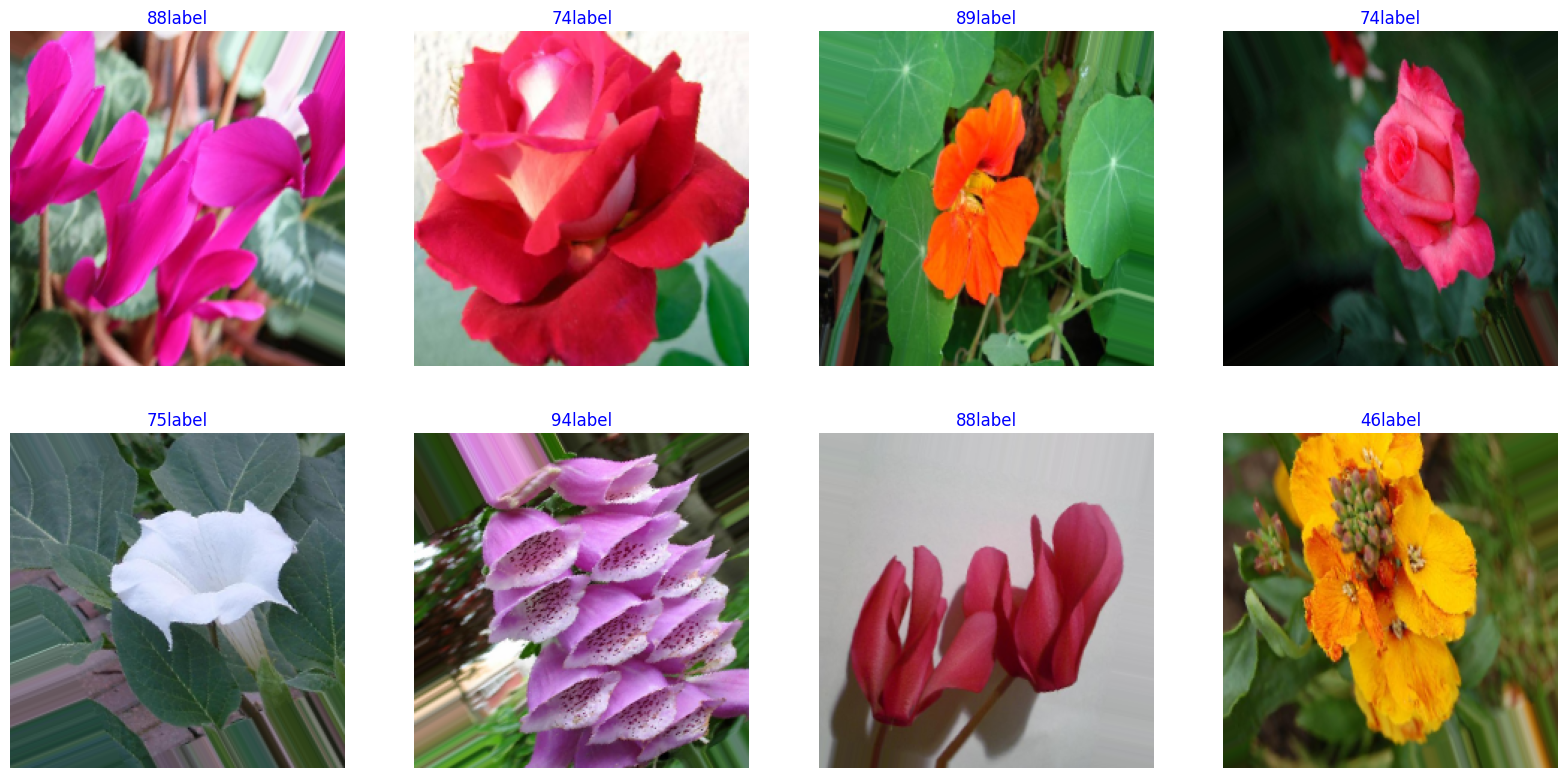

In [131]:
g_dict = train_gen.class_indices
classes = list(g_dict.keys())
images, labels = next(train_gen)
num_samples = len(images)

plt.figure(figsize=(20, 20))

for i in range(min(16, num_samples)):
    plt.subplot(4, 4, i + 1)
    image = images[i] # Không cần chia lại cho 255
    plt.imshow(image)
    class_index = np.argmax(labels[i]) # Lấy index của nhãn cao nhất
    class_name = classes[class_index]
    plt.title(class_name, color='blue', fontsize=12)
    plt.axis('off')
plt.show()

In [132]:
model_VGG16 = VGG16(weights='imagenet', include_top=False)
myFCHead = model_VGG16.output # (None, 1, 1, 2048) # lớp cuối của Conv VGGFace
myFCHead = GlobalAveragePooling2D()(myFCHead) # flatten # Cách 1 # làm phẳng
# myFCHead = Flatten(name='flatten')(myFCHead) # 1x1x2048 = 2048 # Cách 2
myFCHead = Dense(1024, activation='relu')(myFCHead)
myFCHead = Dense(1024, activation='relu')(myFCHead) # double 1024 chỉ để tăng số lượng tham số
myFCHead = Dense(512, activation='relu')(myFCHead)
myFCHead = Dense(128)(myFCHead) # output img is vector 128 dimensional
myModel = Model(inputs=model_VGG16.input, outputs=myFCHead)

In [133]:
# Khởi tạo danh sách để lưu trữ hình ảnh và nhãn
all_images = []
all_labels = []

# Lặp qua từng lô (batch) trong train_gen và lưu trữ hình ảnh và nhãn
for images_batch, labels_batch in train_gen:
    all_images.append(images_batch)
    all_labels.append(labels_batch)
    
    # Kiểm tra xem đã lấy hết dữ liệu từ train_gen chưa
    if len(all_images) * batch_size >= len(train_gen.filenames):
        break

# Ghép các danh sách thành các tensor lớn
all_images = np.concatenate(all_images, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# In shape của tensor hình ảnh và nhãn
print("Shape của tensor hình ảnh:", all_images.shape)
print("Shape của nhãn:", all_labels.shape)

Shape của tensor hình ảnh: (1748, 224, 224, 3)
Shape của nhãn: (1748, 15)


In [134]:
# Dùng pre-trained model để lấy ra các feature của ảnh 
features = myModel.predict(all_images) # tensor Đặc trưng ảnh 

55/55 ━━━━━━━━━━━━━━━━━━━━ 304s 6s/step


In [135]:
features.shape

(1748, 128)

In [136]:
# Khởi tạo danh sách để lưu trữ hình ảnh và nhãn
test_all_images = []
test_all_labels = []

# Lặp qua từng lô (batch) trong train_gen và lưu trữ hình ảnh và nhãn
for images_batch, labels_batch in test_gen:
    test_all_images.append(images_batch)
    test_all_labels.append(labels_batch)
    
    # Kiểm tra xem đã lấy hết dữ liệu từ train_gen chưa
    if len(test_all_images) * batch_size >= len(test_gen.filenames):
        break

# Ghép các danh sách thành các tensor lớn
test_all_images = np.concatenate(test_all_images, axis=0)
test_all_labels = np.concatenate(test_all_labels, axis=0)

# In shape của tensor hình ảnh và nhãn
print("Shape của tensor hình ảnh:", test_all_images.shape)
print("Shape của nhãn:", test_all_labels.shape)

Shape của tensor hình ảnh: (265, 224, 224, 3)
Shape của nhãn: (265, 15)


In [137]:
test_features = myModel.predict(test_all_images) # tensor Đặc trưng ảnh 

9/9 ━━━━━━━━━━━━━━━━━━━━ 43s 5s/step


In [138]:
print(features.shape) # (1748, 7, 7, 512)
print(all_labels.shape) # (1748, 15)
print(test_features.shape) # (8, 7, 7, 512)
print(test_all_labels.shape) # (8, 15)

(1748, 128)
(1748, 15)
(265, 128)
(265, 15)


In [139]:
import numpy as np

def euclidean_distance(vec1, vec2):
    """
    Tính khoảng cách Euclidean giữa hai vector.

    Parameters:
        vec1 (numpy array): Vector thứ nhất.
        vec2 (numpy array): Vector thứ hai.

    Returns:
        float: Khoảng cách Euclidean giữa hai vector.
    """
    return np.linalg.norm(vec1 - vec2)

def predict_labels(train_features, train_labels, test_features):
    """
    Dự đoán nhãn cho các vector trong tập test bằng cách tính khoảng cách
    giữa các vector trong tập test và tất cả các vector trong tập train,
    và chọn nhãn của vector trong tập train có khoảng cách ngắn nhất.

    Parameters:
        train_features (numpy array): Vector đặc trưng của các mẫu trong tập train.
        train_labels (numpy array): Nhãn tương ứng của các mẫu trong tập train.
        test_features (numpy array): Vector đặc trưng của các mẫu trong tập test.

    Returns:
        numpy array: Các nhãn dự đoán cho các mẫu trong tập test.
    """
    predicted_labels = []
    for test_vector in test_features:
        min_distance = float('inf')
        predicted_label = None
        for train_vector, label in zip(train_features, train_labels):
            distance = euclidean_distance(test_vector, train_vector)
            if distance < min_distance:
                min_distance = distance
                predicted_label = label
        predicted_labels.append(predicted_label)
    return np.array(predicted_labels)

# Dự đoán nhãn cho các vector trong tập test
predicted_labels = predict_labels(features, all_labels, test_features)
print(predicted_labels)

[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [140]:
print(predicted_labels.shape)
print(test_all_labels.shape)

(265, 15)
(265, 15)


In [141]:
from sklearn.metrics import accuracy_score
# Tính toán độ chính xác
accuracy = accuracy_score(test_all_labels.argmax(axis=1), predicted_labels.argmax(axis=1)) * 100

print("Accuracy: {:.2f}%".format(accuracy))

Accuracy: 57.74%


In [142]:
from sklearn.metrics import confusion_matrix

# Tính toán ma trận nhầm lẫn
conf_matrix = confusion_matrix(test_all_labels.argmax(axis=1), predicted_labels.argmax(axis=1))

print("Confusion matrix:")
print(conf_matrix)


Confusion matrix:
[[11  0  0  0  0  0  0  0  0  1  2  0  0  0  0]
 [ 0  2  1  2  0  1  1  0  0  1  1  0  2  1  1]
 [ 0  0 14  1  0  1  0  0  3  0  0  0  1  0  0]
 [ 0  0  1 22  1  0  0  0  0  1  0  0  2  0  0]
 [ 0  0  0  2 14  1  0  1  3  0  0  0  0  0  0]
 [ 0  1  2  0  1  9  1  0  0  2  0  1  1  0  0]
 [ 0  1  0  0  0  1  9  0  0  0  0  0  1  0  0]
 [ 0  0  0  1  1  0  0 20  0  1  1  1  1  0  0]
 [ 0  0  0  0  2  1  0  0  9  3  0  0  0  0  0]
 [ 0  0  0  0  3  1  0  1  0 11  1  0  0  0  0]
 [ 0  0  1  3  0  1  0  1  1  0  7  0  0  0  0]
 [ 0  2  1  0  1  4  1  0  1  0  1  6  0  0  0]
 [ 0  0  1  2  1  2  0  0  1  2  3  1  6  0  1]
 [ 0  2  2  1  0  2  0  0  0  0  0  0  1  7  2]
 [ 0  1  0  2  0  1  0  0  1  0  1  0  1  1  6]]


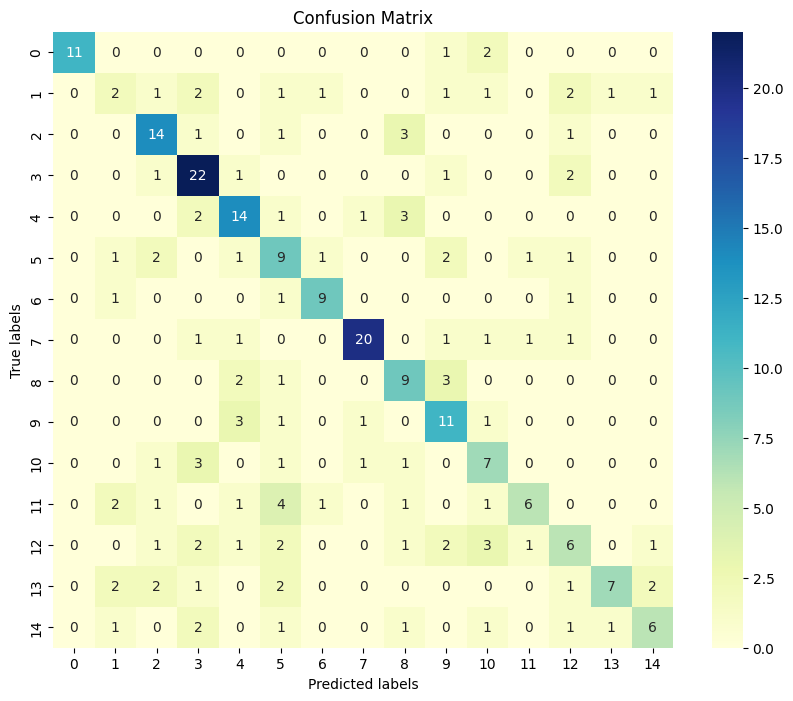

In [143]:
import matplotlib.pyplot as plt
import seaborn as sns

# Tính toán ma trận nhầm lẫn
conf_matrix = confusion_matrix(test_all_labels.argmax(axis=1), predicted_labels.argmax(axis=1))

# Biểu đồ ma trận nhầm lẫn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu", 
            xticklabels=range(conf_matrix.shape[1]), 
            yticklabels=range(conf_matrix.shape[0]))
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()
